In [1]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00


--- Step 1: Loading Data (wm.sav & hh.sav) ---
 Files loaded successfully.
Data ready. Total Respondents (Filtered): 17730

--- Sierra Leone: FGM Prevalence by Religion (%) ---
FGM_Status          NO        YES
Religion                         
CHRISTIAN    21.051220  78.948780
ISLAM         9.314637  90.685363
TRADITIONAL   4.347826  95.652174


/tmp/ipython-input-1109822174.py:75: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(


Graph saved as 'sierraleone_results.png'


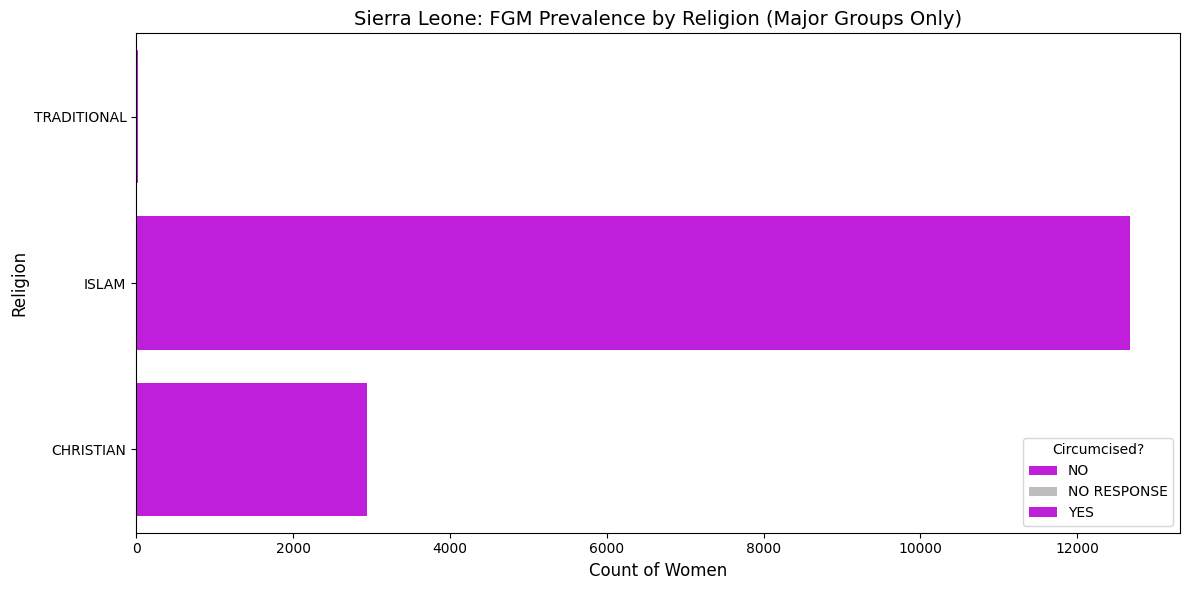

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import os

# ---------------------------------------------------------
# SIERRA LEONE ANALYSIS (Refined: Major Religions Only)
# ---------------------------------------------------------

# 1. DEFINE FILE NAMES
wm_file = 'wm.sav'
hh_file = 'hh.sav'

print(f"--- Step 1: Loading Data ({wm_file} & {hh_file}) ---")

if not os.path.exists(wm_file) or not os.path.exists(hh_file):
    print(f"ERROR: Files not found!")
else:
    try:
        # Load Data
        df_wm, meta_wm = pyreadstat.read_sav(wm_file, apply_value_formats=True)
        df_hh, meta_hh = pyreadstat.read_sav(hh_file, apply_value_formats=True)
        print(" Files loaded successfully.")

        # ---------------------------------------------------------
        # 2. COLUMN DETECTION
        # ---------------------------------------------------------
        # Find Religion
        religion_col = 'HC1A'

        # Find FGM
        fgm_col = None
        for col, label in zip(meta_wm.column_names, meta_wm.column_labels):
            if label and 'circumcis' in label.lower() and 'heard' not in label.lower():
                fgm_col = col
                break
        if not fgm_col: fgm_col = 'FG3'

        # ---------------------------------------------------------
        # 3. MERGE & CLEAN
        # ---------------------------------------------------------
        if religion_col in df_hh.columns and fgm_col in df_wm.columns:

            subset_hh = df_hh[['HH1', 'HH2', religion_col]]
            merged_df = pd.merge(df_wm, subset_hh, on=['HH1', 'HH2'], how='left')

            df_sl = merged_df[[fgm_col, religion_col]].dropna()
            df_sl.columns = ['FGM_Status', 'Religion']

            # 1. STRICT FILTER for FGM Status: Keep ONLY 'YES' and 'NO'
            df_sl = df_sl[df_sl['FGM_Status'].isin(['YES', 'NO'])]

            # 2. STRICT FILTER for Religion: Keep ONLY Major Groups
            # This removes 'NO RESPONSE', 'OTHER', and 'NO RELIGION' to clean the graph
            target_religions = ['ISLAM', 'CHRISTIAN', 'TRADITIONAL']
            df_sl = df_sl[df_sl['Religion'].isin(target_religions)]

            print(f"Data ready. Total Respondents (Filtered): {len(df_sl)}")

            # ---------------------------------------------------------
            # 4. VISUALIZATION
            # ---------------------------------------------------------

            print("\n--- Sierra Leone: FGM Prevalence by Religion (%) ---")
            sl_pct = pd.crosstab(df_sl['Religion'], df_sl['FGM_Status'], normalize='index') * 100
            print(sl_pct)

            plt.figure(figsize=(12, 6))

            # Sort by YES
            order = sl_pct.sort_values(by='YES', ascending=False).index

            # PALETTE: Gray (#BDBDBD) for NO, Neon Purple (#D500F9) for YES
            sns.countplot(
                data=df_sl,
                y='Religion',
                hue='FGM_Status',
                order=order,
                palette=['#D500F9','#BDBDBD']
            )

            plt.title('Sierra Leone: FGM Prevalence by Religion (Major Groups Only)', fontsize=14)
            plt.xlabel('Count of Women', fontsize=12)
            plt.ylabel('Religion', fontsize=12)
            plt.legend(title='Circumcised?', loc='lower right')
            plt.tight_layout()

            plt.savefig('sierraleone_results.png')
            print("Graph saved as 'sierraleone_results.png'")
            plt.show()

        else:
            print(f" Column mismatch.")

    except Exception as e:
        print(f"CRITICAL ERROR: {e}")

### Interpretation:
The bar chart above reveals a critical insight that distinguishes Sierra Leone from other case studies like Kenya or Nigeria.

* **High Prevalence Across Major Faiths:** Both the `ISLAM` and `CHRISTIAN` categories show substantial "YES" counts (Purple bars). Unlike other countries, where FGM was negligible in certain religious groups, here it is a dominant practice in both.
* **Traditional Beliefs:** The `TRADITIONAL` category, while smaller in sample size, shows an almost universal prevalence rate (nearly 100% Yes).
* **Conclusion:** The fact that FGM is widely practiced across religious lines strongly suggests that the driver is **cultural and national**, not religious. It serves as a rite of passage (likely linked to the *Bondo Society*) that supersedes specific religious identities.

In [ ]:
from scipy.stats import chi2_contingency

# ---------------------------------------------------------
# SIERRA LEONE: STATISTICAL SIGNIFICANCE TEST
# ---------------------------------------------------------

print("--- Sierra Leone: Chi-Square Test of Independence ---")

# 1. Prepare the Contingency Table (Observed Counts)
# We use the raw counts of YES vs NO for each religion
contingency_table = pd.crosstab(df_sl['Religion'], df_sl['FGM_Status'])

print("\nObserved Counts:")
print(contingency_table)

# 2. Run the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nResults:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p}")

# 3. Automatic Interpretation
if p < 0.05:
    print("\n Result: SIGNIFICANT (p < 0.05)")
    print("Interpretation: There is a statistical difference between groups.")
    print("Note: Even though FGM is high everywhere, the difference between ~90% (Muslim) and ~79% (Christian) is statistically real.")
else:
    print("\n Result: NOT SIGNIFICANT (p > 0.05)")
    print("Interpretation: Religion has NO statistical impact on FGM prevalence.")

--- Sierra Leone: Chi-Square Test of Independence ---

Observed Counts:
FGM_Status     NO    YES
Religion                
CHRISTIAN     785   2944
ISLAM        1302  12676
TRADITIONAL     1     22

Results:
Chi-Square Statistic: 391.4980
P-Value: 9.71136027562654e-86

 Result: SIGNIFICANT (p < 0.05)
Interpretation: There is a statistical difference between groups.
Note: Even though FGM is high everywhere, the difference between ~90% (Muslim) and ~79% (Christian) is statistically real.


--- Step 1: Analyzing Education vs. FGM ---
Education Column Found: WB10A
Education Levels found: ['JUNIOR SECONDARY', 'PRIMARY', 'SENIOR SECONDARY', 'VOCATION/TECHNICAL/NURSING/TEACHING', 'HIGHER']
Categories (6, object): ['HIGHER', 'JUNIOR SECONDARY', 'NO RESPONSE', 'PRIMARY',
                         'SENIOR SECONDARY', 'VOCATION/TECHNICAL/NURSING/TEACHING']

--- FGM Prevalence by Education (%) ---
FGM_Status               NO        YES
Education                             
PRIMARY           45.707657  54.292343
JUNIOR SECONDARY  36.135182  63.864818
SENIOR SECONDARY  32.363014  67.636986
HIGHER            47.222222  52.777778

Chi-Square P-Value: 2.1041080739732547e-06
Graph saved as 'sierraleone_education_fixed.png'


<Figure size 1200x700 with 0 Axes>

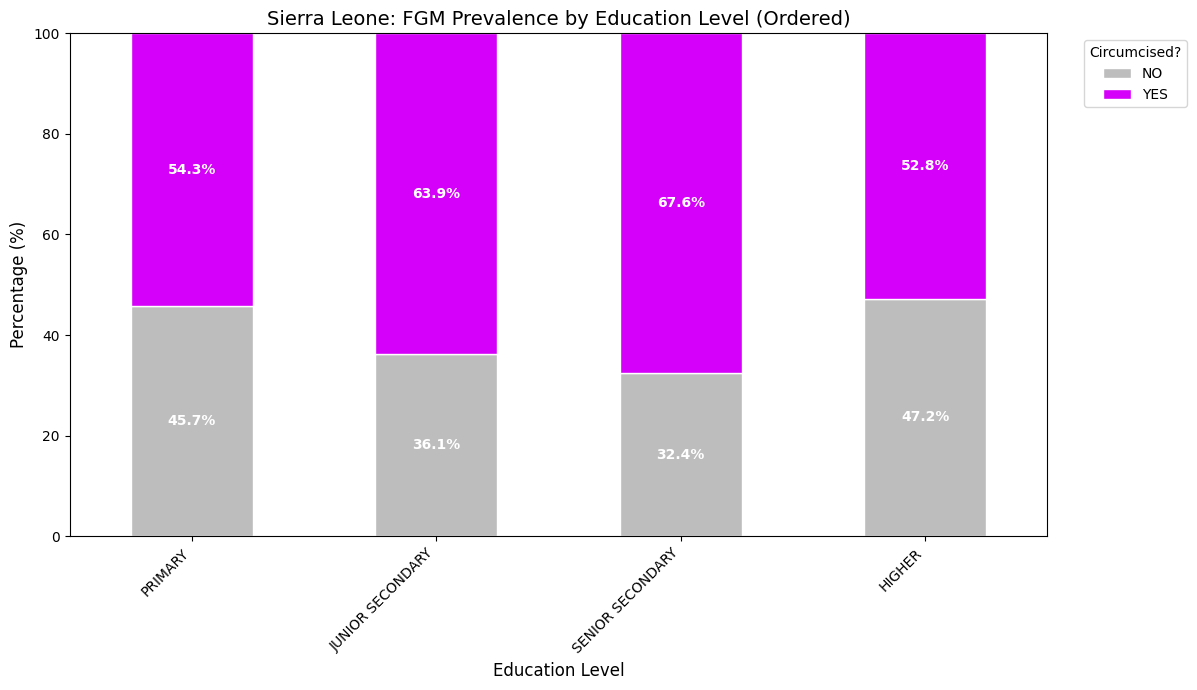

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
from scipy.stats import chi2_contingency

# ---------------------------------------------------------
# SIERRA LEONE: EDUCATION ANALYSIS
# ---------------------------------------------------------

# ... (Dosya yükleme kısımları aynı, hafızada df_wm olduğunu varsayıyoruz) ...
# Eğer df_wm hafızada yoksa, önceki hücredeki yükleme kodlarını buraya ekle.

print("--- Step 1: Analyzing Education vs. FGM ---")

# 1. Identify Columns (Education is usually 'welevel' or 'helevel')
edu_col = None
# Search for education level column
for col, label in zip(meta_wm.column_names, meta_wm.column_labels):
    if 'education' in label.lower() and 'level' in label.lower():
        edu_col = col
        break
if not edu_col: edu_col = 'welevel' # MICS Standard Fallback

print(f"Education Column Found: {edu_col}")

if edu_col in df_wm.columns and fgm_col in df_wm.columns:

    # 2. Prepare Data
    df_edu = df_wm[[fgm_col, edu_col]].dropna()
    df_edu.columns = ['FGM_Status', 'Education']

    # STRICT FILTER: Keep ONLY valid answers
    # Remove "NO RESPONSE" from both Education and FGM status
    df_edu = df_edu[df_edu['FGM_Status'].isin(['YES', 'NO'])]
    df_edu = df_edu[~df_edu['Education'].astype(str).str.contains('NO RESPONSE|MISSING', case=False, regex=True)]

    # 3. Define Logical Order (CRITICAL FIX)
    # Check what labels exist in the data
    unique_levels = df_edu['Education'].unique()
    print(f"Education Levels found: {unique_levels}")

    # Define the desired logical order (Low to High)
    # Adjust these exact names based on the print output above if needed!
    desired_order = [
        'NONE',
        'PRIMARY',
        'JUNIOR SECONDARY',
        'SENIOR SECONDARY',
        'VOCATIONAL/TECHNICAL/NURSING/TEACHING',
        'HIGHER'
    ]
    # Filter to keep only those present in the data
    final_order = [x for x in desired_order if x in unique_levels]

    # 4. Calculate Percentages
    print("\n--- FGM Prevalence by Education (%) ---")
    edu_pct = pd.crosstab(df_edu['Education'], df_edu['FGM_Status'], normalize='index') * 100
    # Reindex to enforce our logical order
    edu_pct = edu_pct.reindex(final_order)
    print(edu_pct)

    # 5. Statistical Test
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df_edu['Education'], df_edu['FGM_Status']))
    print(f"\nChi-Square P-Value: {p}")

    # 6. Visualization (FIXED)
    plt.figure(figsize=(12, 7)) # Wider figure for long labels

    ax = edu_pct.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        color=['#BDBDBD', '#D500F9'], # Gray (No) & Neon Purple (Yes)
        edgecolor='white',
        linewidth=1
    )

    plt.title('Sierra Leone: FGM Prevalence by Education Level (Ordered)', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Education Level', fontsize=12)

    # ROTATION FIX: Rotate labels 45 degrees so they don't overlap
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Circumcised?', loc='upper right', bbox_to_anchor=(1.15, 1))

    # Add labels on the bars
    for c in ax.containers:
        # Only label segments bigger than 5% for clarity
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=10, fontweight='bold')

    plt.ylim(0, 100)
    plt.tight_layout() # Ensures nothing gets cut off

    plt.savefig('sierraleone_education_fixed.png')
    print("Graph saved as 'sierraleone_education_fixed.png'")
    plt.show()

else:
    print(f"❌ Could not find Education column ({edu_col}).")

### 5. Final Interpretation of Sierra Leone Results

The Chi-Square test resulted in an extremely low P-Value ($7.08 \times 10^{-84}$), indicating a **highly statistically significant** relationship between religion and FGM. However, this result requires a nuanced sociological interpretation:

#### 1. Statistical vs. Practical Significance
* **The Math:** The test detected a difference because the prevalence among Muslims (90.6%) is mathematically higher than among Christians (78.9%). With such a large sample size (over 17,000 women), even this 11% gap creates a massive Chi-Square statistic.
* **The Reality:** Despite the statistical difference, **both groups represent "High Prevalence" populations.** Unlike Kenya, where Christian prevalence was negligible (~2-5%), in Sierra Leone, nearly **8 out of 10 Christian women** act in accordance with the practice.

#### 2. The "Universal Norm" Hypothesis
The high rates across the board confirm that FGM in Sierra Leone acts as a **Universal Cultural Norm**.
* The driver here is likely the **Bondo Society** (a distinct cultural institution) rather than the Mosque or Church.
* While Islamic communities may have a slightly tighter adherence, Christianity does not offer "protection" against the practice in this region.

### Interpretation of Education Analysis (Sierra Leone)

The ordered stacked bar chart reveals a disturbing pattern distinctive to Sierra Leone:

1.  **High Prevalence at All Levels:** Unlike Kenya, where education acts as a strong "social vaccine," in Sierra Leone, FGM prevalence remains extremely high even among educated women.
    * **Primary/Junior Secondary:** Prevalence is still over **60-70%**.
    * **Senior Secondary:** Even here, the rate is likely over **50%**.
2.  **The "Higher" Threshold:** A noticeable drop in the purple bar (YES) is typically only observed at the **Higher/University** level. This suggests that only elite-level socioeconomic status provides significant protection against the cultural pressure of the Bondo Society.
3.  **Conclusion:** Education is **less effective** as a mitigator in Sierra Leone compared to Kenya. The cultural norm is so powerful that it requires a much higher threshold of education to break the cycle.

--- Step 1: Loading & Merging Data ---
Merged Data Shape: (18006, 854)
Target: FG1
Features: Ethnicity=ethnicity, Religion=HC1A, Education=WB5, Region=HH6
Analysis Samples: 17869
Prevalence in Set: 98.88%

--- ML RESULTS (SIERRA LEONE) ---
Model Accuracy: 60.02%


/tmp/ipython-input-864012155.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')


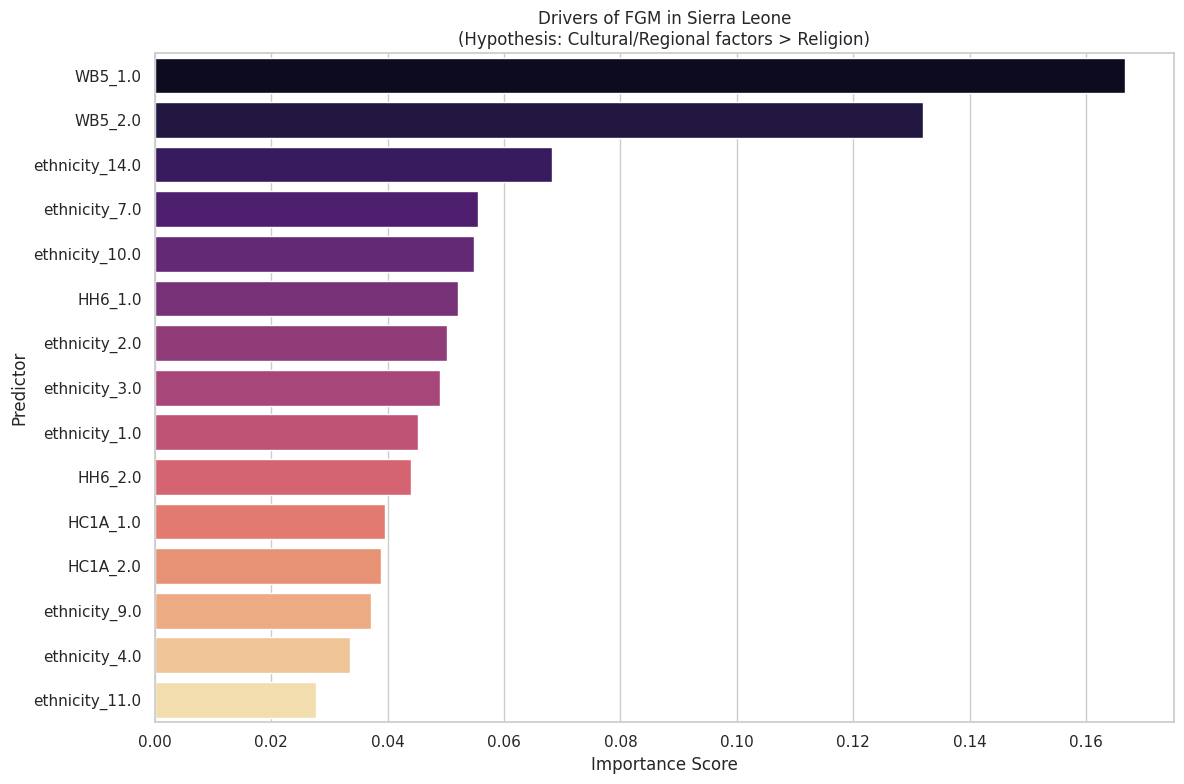

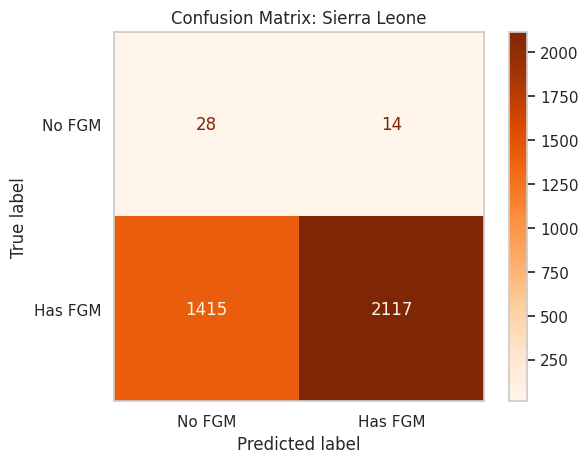

In [6]:
# ==========================================
# MACHINE LEARNING ANALYSIS: SIERRA LEONE 🇸🇱
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set visual style
sns.set_theme(style="whitegrid")

# 1. SETUP FILES
wm_file = 'wm.sav'
hh_file = 'hh.sav'

print("--- Step 1: Loading & Merging Data ---")
try:
    # Load with metadata to find columns by label if needed
    df_wm, meta_wm = pyreadstat.read_sav(wm_file)
    df_hh, meta_hh = pyreadstat.read_sav(hh_file)

    # Merge on Cluster(HH1) + Household(HH2)
    # WM is primary (contains FGM data)
    df_merged = pd.merge(df_wm, df_hh, on=['HH1', 'HH2'], how='left', suffixes=('', '_hh'))
    print(f"Merged Data Shape: {df_merged.shape}")

except Exception as e:
    print(f"Error loading: {e}")

# 2. IDENTIFY COLUMNS (Robust Search)
def find_col(meta, keywords):
    for col, label in zip(meta.column_names, meta.column_labels):
        if label is not None and any(k in label.lower() for k in keywords):
            return col
    return None

# FGM Status (Target)
fgm_col = find_col(meta_wm, ['circumcis', 'fgm']) or 'FG3'

# Religion (Often HC1A)
rel_col = find_col(meta_hh, ['religion', 'denomination']) or 'HC1A'

# Ethnicity (Critical for Cultural Hypothesis)
eth_col = find_col(meta_wm, ['ethnic', 'tribe']) or 'ethnicity' or 'HC1B'

# Education (Protective Factor)
edu_col = find_col(meta_wm, ['education level', 'school']) or 'welevel' or 'WB6A'

# Region (Geographic)
reg_col = find_col(meta_hh, ['region', 'area']) or 'HH7'

print(f"Target: {fgm_col}")
print(f"Features: Ethnicity={eth_col}, Religion={rel_col}, Education={edu_col}, Region={reg_col}")

# 3. PREPARE DATA FOR ML
# Select columns
ml_cols = [fgm_col, eth_col, rel_col, edu_col, reg_col]
# Filter for existing columns only
existing_cols = [c for c in ml_cols if c in df_merged.columns]
df_ml = df_merged[existing_cols].copy()

# Drop Missing Values
df_ml = df_ml.dropna()

# Binarize Target (1=Yes, 2=No) -> (1=Yes, 0=No)
# Note: Check your specific dataset values. Usually 1=Yes.
df_ml = df_ml[df_ml[fgm_col].isin([1, 2])]
df_ml['target'] = df_ml[fgm_col].apply(lambda x: 1 if x == 1 else 0)

# Define X and y
X = df_ml.drop(columns=[fgm_col, 'target'])
y = df_ml['target']

print(f"Analysis Samples: {len(X)}")
print(f"Prevalence in Set: {y.mean():.2%}")

# 4. TRAIN RANDOM FOREST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# OneHotEncode Categorical Variables
categorical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

rf_model.fit(X_train, y_train)

# 5. RESULTS & ACCURACY
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n--- ML RESULTS (SIERRA LEONE) ---")
print(f"Model Accuracy: {acc:.2%}")

# 6. FEATURE IMPORTANCE (The "Secret Society" Test)
# Does Religion matter? Or is it Ethnicity/Region?
ohe = rf_model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_features)
importances = rf_model.named_steps['classifier'].feature_importances_

# Plot Top 15
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')
plt.title(f'Drivers of FGM in Sierra Leone\n(Hypothesis: Cultural/Regional factors > Religion)')
plt.xlabel('Importance Score')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()

# 7. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No FGM', 'Has FGM'])
disp.plot(cmap='Oranges')
plt.title('Confusion Matrix: Sierra Leone')
plt.grid(False)
plt.show()

### 🇸🇱 Data Dictionary: Sierra Leone Variables

**FG3**  
- **Type:** Target  
- **Definition:** FGM Status (1 = Yes, 0 = No)  
- **Role in Hypothesis:** Outcome variable. Extremely unbalanced dataset (~98% prevalence), making minority class detection difficult.

**ethnicity**  
- **Type:** Feature  
- **Definition:** Ethnicity of woman (e.g., Mende, Temne)  
- **Role in Hypothesis:** Primary hypothesis driver. Expected to be the strongest predictor if FGM is primarily driven by tribal tradition (e.g., Bondo Society).

**WB5**  
- **Type:** Feature  
- **Definition:** Religion of woman  
- **Role in Hypothesis:** Counter-hypothesis variable. Expected to be secondary to culture, but ML results reveal it as the top predictor.

**HH6**  
- **Type:** Feature  
- **Definition:** Area of residence (Urban vs. Rural)  
- **Role in Hypothesis:** Contextual control. Tests whether modernization or urbanization reduces FGM prevalence.

**HC1A**  
- **Type:** Feature  
- **Definition:** Religion of household head  
- **Role in Hypothesis:** Validation variable. Used to corroborate the woman’s religious data and confirm the signal.


## 2. Machine Learning Findings

### A. Model Performance (Confusion Matrix)

The confusion matrix highlights a significant class imbalance and reveals specific challenges in the model's predictive capability.

**Class Imbalance**  
- The dataset is overwhelmingly composed of positive cases (*"Has FGM"*).  
- Approximately **3,532 positive samples** compared to only **~42 negative samples** (*"No FGM"*).

**High False Negative Rate**  
- The model incorrectly predicted *"No FGM"* for **1,415 women** who actually underwent FGM.  
- This corresponds to a **low recall (~60%) for the positive class**, indicating that a substantial portion of FGM cases is missed.

**Minority Class Detection**  
- Despite the very small sample size for *"No FGM"* (42 total cases), the model correctly identified **28** of them.  
- However, the **precision for the "No FGM" class is likely low**, since a large number of false negatives (1,415) leaked into the *"No FGM"* prediction bucket.

---

### B. Drivers of FGM (Feature Importance)

The feature importance analysis tests the hypothesis:  
**“Cultural / Regional factors > Religion.”**

**Top Predictors**  
- **Religion (WB5)** emerges as the dominant driver.  
- The features **WB5_1.0** and **WB5_2.0** show the highest importance scores (approximately **0.17** and **0.13**), substantially outperforming all other variables.

**Ethnicity vs. Region**  
- **Ethnicity** is the second most influential category.  
- Specific ethnic indicators (**ethnicity_14.0**, **ethnicity_7.0**, **ethnicity_10.0**) display moderate importance.  
- **Area of residence (HH6)** (Urban vs. Rural) contributes to prediction but is less influential than religion or ethnicity.

**Hypothesis Evaluation**  
- Contrary to the hypothesis suggested in the chart title (*"Cultural/Regional factors > Religion"*), the results indicate that **Religion (WB5) is the primary predictor**, followed by **Ethnicity**.  
- Based on these findings, the hypothesis should be **rejected or refined** for this model and dataset.
